<a href="https://colab.research.google.com/github/gabyneko88/Proyecto_Telecom/blob/main/telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

### Ejercicio

****El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)



El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

Haz una lista de 5 a 10 fuentes (documentación, artículos, etc) que usaste mientras trabajabas en el proyecto. Brinda explicaciones breves sobre las preguntas que cada fuente te ayudó a responder. Prepara una presentación con tus conclusiones. Puedes usar cualquier herramienta que quieras para hacer la presentación, pero debes enviarla en PDF. Coloca el enlace en el cuerpo del proyecto principal.

## Descomposición

Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

**Plan de Trabajo**

1. **Preparación y exploración inicial (EDA)**

 - Cargar datasets: telecom_dataset_us.csv y telecom_clients_us.csv.

 - Revisar estructura y dimensiones de los datos (shape, tipos de variables).

 - Explorar valores faltantes y duplicados, y definir cómo manejarlos.

 - Analizar rangos y distribuciones de variables clave (calls_count, call_duration, total_call_duration, is_missed_call).

 - Verificar coherencia temporal de las fechas (date, date_start).

2. **Definición de KPI's y umbrales de ineficacia**

 - Proporción de llamadas perdidas por operador:

Missed Call Rate

- llamadas perdidas
- total de llamadas entrantes

Tiempo promedio de espera en llamadas entrantes:

Avg Waiting Time

- total_call_duration – call_duration

llamadas entrantes
Avg Waiting Time = llamadas entrantes

total_call_duration – call_duration

 - Volumen de llamadas salientes: comparación de cada operador contra la media/percentil del grupo que debería hacer llamadas salientes.

Definir umbrales con base en:

 - Distribución de los datos (percentiles o desviaciones estándar).

 - Revisión de literatura o benchmarks (ej., 20–30% missed calls considerado crítico en call centers, >180–200s de espera excesivo).

 - Documentar justificación de cada umbral.


3. **Identificación de operadores ineficaces**

 - Calcular los KPIs definidos por operador y fecha.

 - Clasificar a los operadores en eficaces vs. ineficaces según los umbrales.

 - Identificar patrones por cliente (user_id) y por plan tarifario (tariff_plan).


Visualizar resultados en:

- Histogramas y boxplots (tiempos de espera, % de llamadas perdidas).

- Tablas de ranking de operadores con peor desempeño.


4. **Pruebas estadísticas**


Hipótesis 1 (llamadas perdidas):

- H₀: La proporción de llamadas perdidas de los operadores ineficaces no difiere de la de los demás.

- H₁: La proporción de llamadas perdidas de los operadores ineficaces es significativamente mayor.



Hipótesis 2 (tiempo de espera):

- H₀: El tiempo promedio de espera no difiere entre operadores eficaces e ineficaces.

- H₁: Los operadores ineficaces tienen tiempos de espera significativamente mayores.





Hipótesis 3 (llamadas salientes):

- H₀: No hay diferencia en el número de llamadas salientes realizadas por operadores clasificados como ineficaces.

- H₁: Los operadores ineficaces realizan significativamente menos llamadas salientes.



## Preparación y exploración inicial (EDA)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pytz
from scipy import stats
from scipy.stats import shapiro, mannwhitneyu

In [ ]:
df_llamadas = pd.read_csv ("/datasets/telecom_dataset_us.csv")
df_clientes = pd.read_csv("/datasets/telecom_clients_us.csv")

In [ ]:
df_llamadas['date'] = pd.to_datetime(df_llamadas['date'], format='%Y-%m-%d')
df_llamadas['date'] = pd.to_datetime(df_llamadas['date'], format='%Y-%m-%d')
# Convertir a la zona horaria UTC
df_llamadas['date'] = df_llamadas['date'].dt.tz_convert('UTC')
df_llamadas['fecha'] = df_llamadas['date'].dt.date
df_llamadas['fecha'] = pd.to_datetime(df_llamadas['fecha'], format='%Y-%m-%d')
df_llamadas.drop('date', axis=1, inplace=True)
df_llamadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              53902 non-null  int64         
 1   direction            53902 non-null  object        
 2   internal             53785 non-null  object        
 3   operator_id          45730 non-null  float64       
 4   is_missed_call       53902 non-null  bool          
 5   calls_count          53902 non-null  int64         
 6   call_duration        53902 non-null  int64         
 7   total_call_duration  53902 non-null  int64         
 8   fecha                53902 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


In [ ]:
df_llamadas['operator_id'] = df_llamadas['operator_id'].replace(' ', np.nan)
df_llamadas.isnull().sum()

user_id                   0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
fecha                     0
dtype: int64

In [ ]:
df_llamadas['internal'] = df_llamadas['internal'].fillna(False)
df_llamadas['operator_id'] = df_llamadas['operator_id'].fillna('desconocido')

In [ ]:
df_llamadas.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,fecha
0,166377,in,False,desconocido,True,2,0,4,2019-08-03
1,166377,out,True,880022.0,True,3,0,5,2019-08-04
2,166377,out,True,880020.0,True,1,0,1,2019-08-04
3,166377,out,True,880020.0,False,1,10,18,2019-08-04
4,166377,out,False,880022.0,True,3,0,25,2019-08-04


In [ ]:
# Calculando estadísticas descriptivas
df_llamadas.describe()

,user_id,calls_count,call_duration,total_call_duration
count,53902.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,16.451245,866.684427,1157.133297
std,598.883775,62.917170,3731.791202,4403.468763
min,166377.000000,1.000000,0.000000,0.000000
25%,166782.000000,1.000000,0.000000,47.000000
50%,167162.000000,4.000000,38.000000,210.000000
75%,167819.000000,12.000000,572.000000,902.000000
max,168606.000000,4817.000000,144395.000000,166155.000000


Conclusiones:

Existe una gran variabilidad en el número de llamadas, la duración de las llamadas y la duración
total de las llamadas por usuario. Esto sugiere que tenemos una población de usuarios bastante
heterogénea en términos de su comportamiento de llamadas.

Posibles outliers, los valores mínimos y máximos de call_duration y total_call_duration sugieren
la presencia de outliers (valores atípicos).

## Definición de KPIs y umbrales de ineficacia

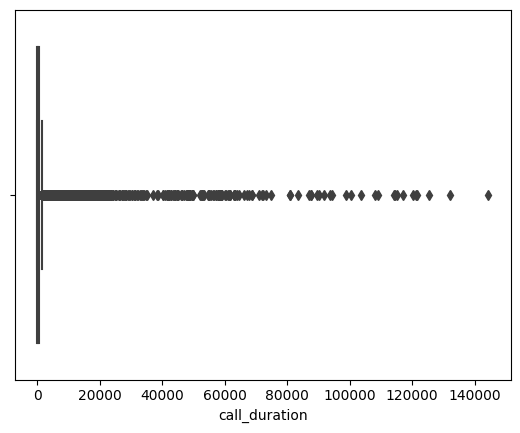

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,fecha
21,166377,out,False,880028.0,False,17,1603,1725,2019-08-08
24,166377,out,False,880028.0,False,20,2074,2191,2019-08-11
41,166377,out,False,880028.0,False,18,2686,2782,2019-08-13
43,166377,out,False,880026.0,False,10,1567,1654,2019-08-13
44,166377,out,False,880026.0,False,10,1567,1654,2019-08-13
...,...,...,...,...,...,...,...,...,...
53848,168601,out,False,952914.0,False,46,2614,3221,2019-11-13
53850,168601,out,False,952914.0,False,17,1472,1705,2019-11-14
53865,168601,out,False,952914.0,False,30,1650,2119,2019-11-24
53899,168606,out,True,957922.0,False,4,3130,3190,2019-11-14


In [ ]:
# Crear un boxplot para visualizar outliers en la columna 'call_duration'
sns.boxplot(x='call_duration', data=df_llamadas)
plt.show()
# Calcular el IQR y los límites para identificar outliers
Q1 = df_llamadas['call_duration'].quantile(0.25)
Q3 = df_llamadas['call_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = df_llamadas[
    (df_llamadas['call_duration']
    < lower_bound)
    |
    (df_llamadas['call_duration']
    > upper_bound)
    ]
outliers

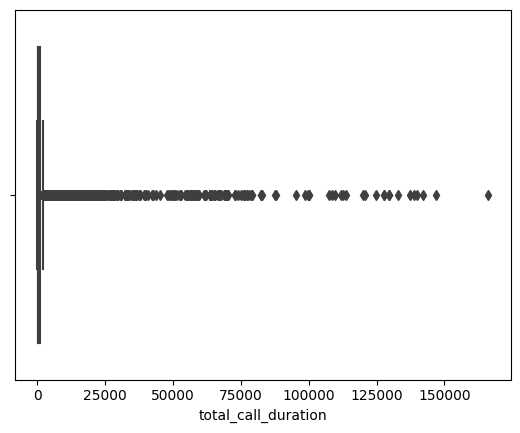

In [ ]:
# Crear un boxplot para visualizar outliers en la columna 'total_call_duration'
sns.boxplot(x='total_call_duration', data=df_llamadas)
plt.show()
# Calcular el IQR y los límites para identificar outliers
Q1 = df_llamadas['total_call_duration'].quantile(0.25)
Q3 = df_llamadas['total_call_duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = df_llamadas[
    (df_llamadas['total_call_duration']
    < lower_bound)
    |
    (df_llamadas['total_call_duration']
    > upper_bound)
    ]

In [ ]:
# Calcular los percentiles 95 para ambas columnas
percentil_95_call_duration = np.percentile(
    df_llamadas['call_duration'],95
)
percentil_95_total_call_duration = np.percentile(
    df_llamadas['total_call_duration'], 95
)

print(percentil_95_call_duration)
print(percentil_95_total_call_duration)

3739.949999999997
4540.0


In [ ]:
# Calcular el número de llamadas que superan el percentil 95 para cada columna
num_llamadas_sobre_percentil_95_call_duration = df_llamadas[
    df_llamadas['call_duration']
    > percentil_95_call_duration
    ].shape[0]
num_llamadas_sobre_percentil_95_total_call_duration = df_llamadas[
    df_llamadas['total_call_duration']
    > percentil_95_total_call_duration
    ].shape[0]
print("Número de llamadas con duración superior al percentil 95:",
      num_llamadas_sobre_percentil_95_call_duration
     )
print("Número de llamadas con duración total superior al percentil 95:",
      num_llamadas_sobre_percentil_95_total_call_duration
     )

Número de llamadas con duración superior al percentil 95: 2696
Número de llamadas con duración total superior al percentil 95: 2695


In [ ]:
 # Calcular el número de llamadas que superan el percentil 95 para cada columna
num_llamadas_sobre_percentil_95_call_duration = df_llamadas[
    df_llamadas['call_duration']
    > percentil_95_call_duration
    ].shape[0]
print("Número de llamadas con duración superior al percentil 95:",
      num_llamadas_sobre_percentil_95_call_duration
     )

# Crear una nueva columna para categorizar las llamadas
df_llamadas['tipo_llamada'] = np.where(
    df_llamadas['call_duration']
    > percentil_95_call_duration,
    'Llamada larga','Llamada estándar'
)
# Visualizar las primeras filas para verificar
print(df_llamadas.head())

Número de llamadas con duración superior al percentil 95: 2696
   user_id direction  internal  operator_id  is_missed_call  calls_count  \
0   166377        in     False  desconocido            True            2   
1   166377       out      True     880022.0            True            3   
2   166377       out      True     880020.0            True            1   
3   166377       out      True     880020.0           False            1   
4   166377       out     False     880022.0            True            3   

   call_duration  total_call_duration      fecha      tipo_llamada  
0              0                    4 2019-08-03  Llamada estándar  
1              0                    5 2019-08-04  Llamada estándar  
2              0                    1 2019-08-04  Llamada estándar  
3             10                   18 2019-08-04  Llamada estándar  
4              0                   25 2019-08-04  Llamada estándar  


Conclusiones:

Como la cantidad de llamadas por encima del percentil 95, es un numero considerable. Se creo una
columna con la categoria de llamadas largas y asi usar estos datos en futuros analisis.

In [ ]:
# Crear un df sin los outliers
df_llamadas_2 = df_llamadas[
    (df_llamadas['call_duration']
    <= percentil_95_call_duration)
    &
    (df_llamadas['total_call_duration']
    <= percentil_95_total_call_duration)
    ]

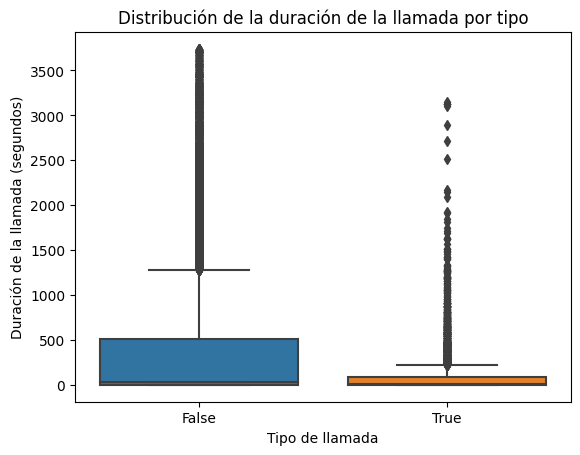

In [ ]:
sns.boxplot(x='internal', y='call_duration', data=df_llamadas_2)
plt.xlabel('Tipo de llamada')
plt.ylabel('Duración de la llamada (segundos)')
plt.title('Distribución de la duración de la llamada por tipo')
plt.show()

Las llamadas internas presentan una duración significativamente mayor que las externas. Esto
sugiere que las interacciones entre operadores y clientes suelen requerir más tiempo para resolverse.

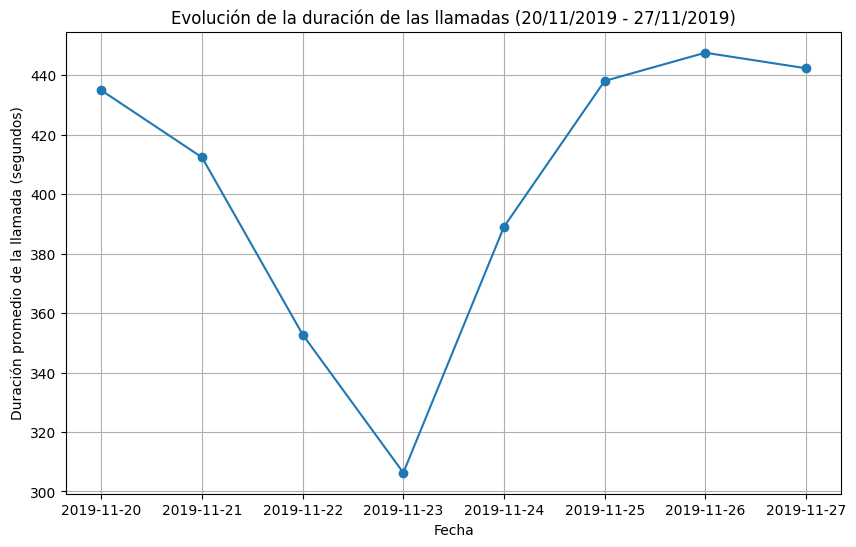

In [ ]:
# Filtramos las llamadas de la semana del 20 al 27 de noviembre de 2019
df_semana = df_llamadas_2[
    (df_llamadas_2['fecha'] >= '2019-11-20')
    &
    (df_llamadas_2['fecha'] <= '2019-11-27')
    ]

# Agrupamos los datos por día y calculamos la duración promedio de las llamadas
df_agrupado = df_semana.groupby('fecha')['call_duration'].mean().reset_index()

# Creamos el gráfico de línea
x = df_agrupado['fecha']
y = df_agrupado['call_duration']

plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o')
plt.xlabel('Fecha')
plt.ylabel('Duración promedio de la llamada (segundos)')
plt.title('Evolución de la duración de las llamadas (20/11/2019 - 27/11/2019)')
plt.grid(True)
plt.show()

La duración promedio de las llamadas presentó un patrón interesante durante la semana del 20
al 27 de noviembre. Se observa una disminución inicial seguida de un incremento sostenido. Este comportamiento sugiere la posible influencia de factores externos, como promociones, campañas o cambios en los procesos internos, que podrían haber afectado la complejidad y duración de las interacciones con los clientes.

La eliminación de los outliers en las columnas ‘call_duration’ y ‘total_call_duration’ ha resultado
en una reducción significativa de la desviación estándar, lo que indica una menor dispersión de los
datos. Al establecer un límite en el percentil 95 y eliminar los valores superiores, se ha logrado
obtener una distribución de datos más homogénea, facilitando así el análisis y la interpretación de
los resultados.

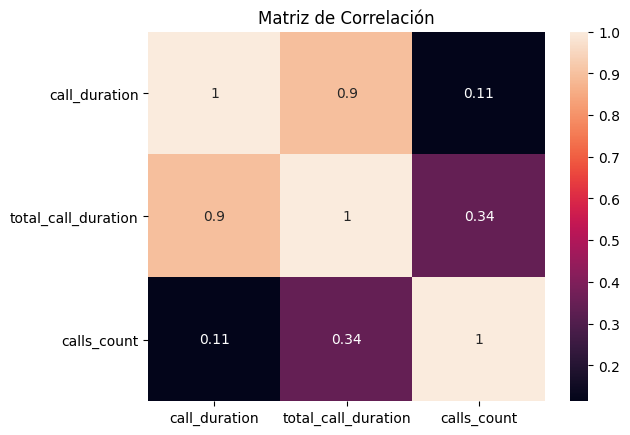

In [ ]:
# Seleccionar solo las columnas numéricas continuas relevantes
columnas_numericas = ['call_duration','total_call_duration', 'calls_count']
df_numericas_continuas = df_llamadas_2[columnas_numericas]

# Calcular la matriz de correlación
cm = df_numericas_continuas.corr()

# Visualizar la matriz de correlación
sns.heatmap(cm, annot=True)
plt.title("Matriz de Correlación")
plt.show()

La matriz de correlación muestra una fuerte relación positiva entre la duración de las llamadas
individuales (call_duration) y la duración total de las llamadas (total_call_duration), lo que es
esperable. Sin embargo, la relación entre el número total de llamadas (calls_count) y las otras dos variables es más débil, sugiriendo que la eficiencia de los operadores podría influir en la duración total de las llamadas, independientemente del número de ellas. También podría sugerir que los usuarios están teniendo dificultades para resolver sus problemas en una sola llamada.

## Identificación de operadores ineficaces

In [ ]:
# Agrupar por operador y calcular la tasa de llamadas perdidas
grouped_data = df_llamadas_2\
                .groupby('operator_id')\
                .agg(missed_call_rate=('is_missed_call','mean'))

# Ordenar por tasa de llamadas perdidas de mayor a menor
sorted_data = grouped_data.sort_values(by='missed_call_rate', ascending=False)

# Establecer umbral
llamadas_perdidas_limite= 0.30

# Identificar operadores ineficientes
inefficient_operators = sorted_data[
    sorted_data['missed_call_rate']
    > llamadas_perdidas_limite
    ]

# Contar los operadores ineficientes
num_inefficient_operators = len(inefficient_operators)
print("Número de operadores con alto porcentaje de llamadas perdidas:" ,
      num_inefficient_operators
     )

# Mostrar los operadores ineficientes
print(inefficient_operators)

Número de operadores con alto porcentaje de llamadas perdidas: 635
             missed_call_rate
operator_id                  
936296.0             1.000000
905480.0             1.000000
937772.0             1.000000
885682.0             1.000000
937770.0             1.000000
...                       ...
962268.0             0.303030
925826.0             0.302521
937860.0             0.302326
900826.0             0.301676
906400.0             0.301205

[635 rows x 1 columns]


In [ ]:
df_llamadas_2['operator_id'].nunique()

1093

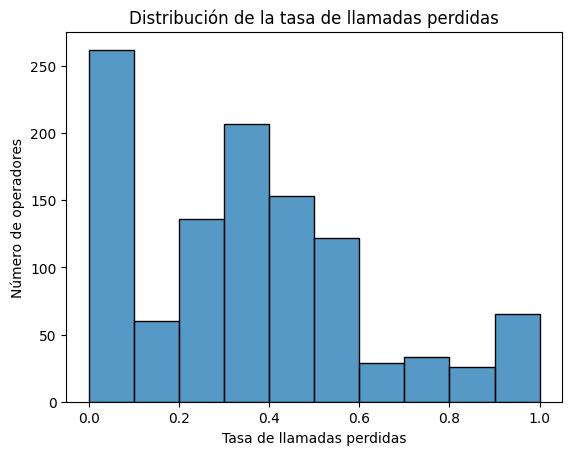

In [ ]:
# Histograma
sns.histplot(data=sorted_data, x='missed_call_rate', bins=10)
plt.title('Distribución de la tasa de llamadas perdidas')
plt.xlabel('Tasa de llamadas perdidas')
plt.ylabel('Número de operadores')
plt.show()

La mayoría de los operadores presentan una tasa de llamadas perdidas baja, concentrándose en
el rango entre 0 y 0.4. Sin embargo, existe un grupo considerable de operadores con tasas más
elevadas, lo que sugiere la necesidad de implementar acciones para mejorar la eficiencia en la
atención al cliente

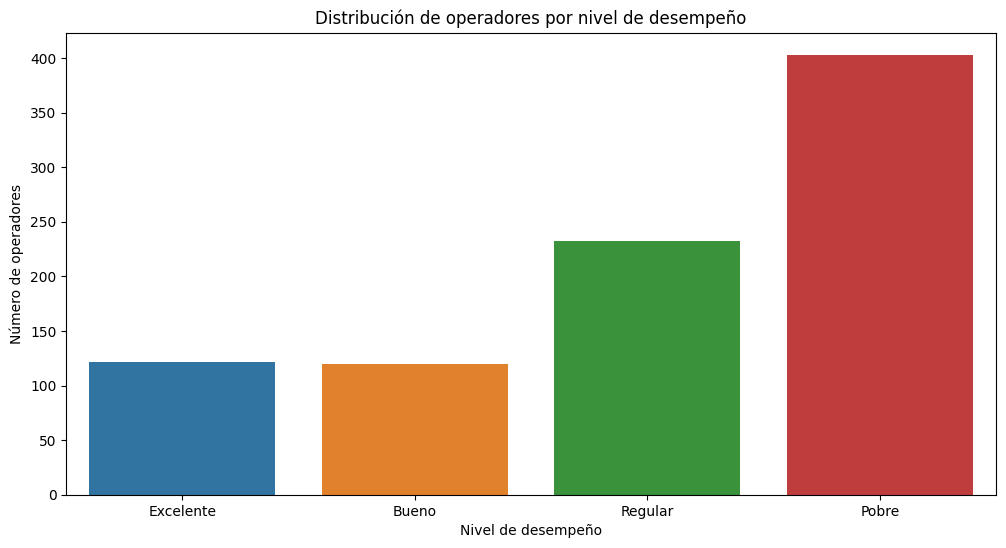

In [ ]:
# Definir los rangos de desempeño para mejor visibilidad de patrones
bins = [0, 0.2, 0.3, 0.4, 1]
labels = ['Excelente', 'Bueno','Regular','Pobre']

# Crear una nueva columna con los rangos de desempeño
sorted_data['desempeño'] = pd.cut(sorted_data['missed_call_rate'], bins=bins, labels=labels)

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.countplot(x='desempeño', data=sorted_data, order=labels)
plt.title('Distribución de operadores por nivel de desempeño')
plt.xlabel('Nivel de desempeño')
plt.ylabel('Número de operadores')
plt.show()

Si tenemos 1093 operadores en total y 635 tienen una tasa de llamadas perdidas superior al 30%,
estamos hablando de aproximadamente el 58% del equipo. Esto es un porcentaje considerable y sugiere un problema sistémico más allá de casos individuales.

Impacto que representa para el negocio una tasa de llamadas perdidas tan alta puede tener un
choque negativo significativo en la reputación de la empresa, la satisfacción del cliente y, en última
instancia, en los ingresos. Los clientes que no pueden comunicarse con un agente pueden optar por buscar los servicios de la competencia.

El análisis de la tasa de llamadas perdidas por operador revela una amplia gama de desempeños.
Si bien la mayoría de los operadores mantienen tasas bajas, un grupo significativo presenta tasas
significativamente más altas. Es necesario investigar las causas de estas diferencias, como la experiencia del operador, la complejidad de las llamadas o problemas técnicos, para implementar acciones correctivas y garantizar un servicio de calidad.

El gráfico de barras evidencia una clara necesidad de implementar programas de capacitación y
desarrollo para los operadores que se encuentran en las categorías “Regular” y “Pobre”. Además,
sería conveniente realizar un análisis más detallado de los factores que influyen en el desempeño de cada operador, como la experiencia, la carga de trabajo o los recursos disponibles.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Bien, los criterios para identificar el desempeño de los operadores quedó súper claro y está basado totalmente en los datos análizados lo cual demuestra un gran dominio y capacidad de análisis
</div>

## Pruebas estadísticas


**Hipótesis 1 (llamadas perdidas):**

- H₀: La proporción de llamadas perdidas de los operadores ineficaces no difiere de la de los demás.

- H₁: La proporción de llamadas perdidas de los operadores ineficaces es significativamente mayor.

In [ ]:
# Calcular métricas adicionales por operador
grouped_data = df_llamadas_2\
    .groupby('operator_id')\
    .agg(missed_call_rate=('is_missed_call', 'mean'),
         total_calls=('calls_count', 'sum'),
         avg_call_duration=('call_duration','mean')
        )

# Dividir los datos en dos grupos
high_missed_calls = grouped_data[grouped_data['missed_call_rate'] > 0.3]
low_missed_calls = grouped_data[grouped_data['missed_call_rate'] <= 0.3]

# Verificar normalidad de la duración promedio de las llamadas en ambos grupos
# Grupo con alta tasa de llamadas perdidas
stat, p = stats.shapiro(high_missed_calls['avg_call_duration'])

print('Grupo con alta tasa de llamadas perdidas:')
print('Estadístico de Shapiro-Wilk:', stat)
print('p-valor:', p)

if p > 0.05:
    print('Los datos se distribuyen aproximadamente de forma normal')
else:
    print('Los datos no se distribuyen de forma normal')
print('-------------------------------------------------------------')

# Grupo con baja tasa de llamadas perdidas
stat, p = stats.shapiro(low_missed_calls['avg_call_duration'])

print('Grupo con baja tasa de llamadas perdidas:')
print('Estadístico de Shapiro-Wilk:', stat)
print('p-valor:', p)
if p > 0.05:
    print('Los datos se distribuyen aproximadamente de forma normal')
else:
    print('Los datos no se distribuyen de forma normal')

Grupo con alta tasa de llamadas perdidas:
Estadístico de Shapiro-Wilk: 0.928991436958313
p-valor: 9.061032382856921e-17
Los datos no se distribuyen de forma normal
-------------------------------------------------------------
Grupo con baja tasa de llamadas perdidas:
Estadístico de Shapiro-Wilk: 0.5778684616088867
p-valor: 8.375935626021475e-32
Los datos no se distribuyen de forma normal


In [ ]:
# Comparar el número total de llamadas atendidas (prueba de Mann-Whitney U)
U_stat, p_value = stats.mannwhitneyu(
    high_missed_calls['total_calls'],
    low_missed_calls['total_calls']
)

print('Comparación del número total de llamadas atendidas:')
print('Estadístico U:', U_stat)
print('p-valor:', p_value)
print('-------------------------------------------------------------')

# Comparar la duración promedio de las llamadas (prueba de Mann-Whitney U)
U_stat, p_value = stats.mannwhitneyu(high_missed_calls['avg_call_duration'],
low_missed_calls['avg_call_duration'])

print('Comparación de la duración promedio de las llamadas:')
print('Estadístico U:', U_stat)
print('p-valor:', p_value)

Comparación del número total de llamadas atendidas:
Estadístico U: 220403.0
p-valor: 4.6814544238210916e-48
-------------------------------------------------------------
Comparación de la duración promedio de las llamadas:
Estadístico U: 183130.5
p-valor: 2.393128334781647e-13


Los resultados obtenidos indican una relación clara y significativa entre la tasa de llamadas perdidas
y el desempeño de los operadores. Los operadores con una alta tasa de llamadas perdidas tienen
un menor volumen de trabajo y una menor duración promedio de las llamadas, lo que sugiere una
necesidad de mejorar sus prácticas y procesos.

In [ ]:
# Filtrar las llamadas entrantes
llamadas_entrantes = df_llamadas_2[df_llamadas_2['direction'] == 'in']

# Calcular el tiempo total de espera
tiempo_total_espera = llamadas_entrantes['total_call_duration'].sum()\
                    - llamadas_entrantes['call_duration'].sum()

# Calcular el número total de llamadas entrantes
numero_llamadas_entrantes = llamadas_entrantes['calls_count'].sum()

# Calcular el tiempo de espera promedio
tiempo_espera_promedio = tiempo_total_espera / numero_llamadas_entrantes

print("El tiempo de espera promedio para las llamadas entrantes es:",
      tiempo_espera_promedio,
      "segundos"
     )

El tiempo de espera promedio para las llamadas entrantes es: 12.739733972839575 segundos


/tmp/ipykernel_2344/972329709.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llamadas_entrantes['tiempo_espera'] = llamadas_entrantes['total_call_duration']\


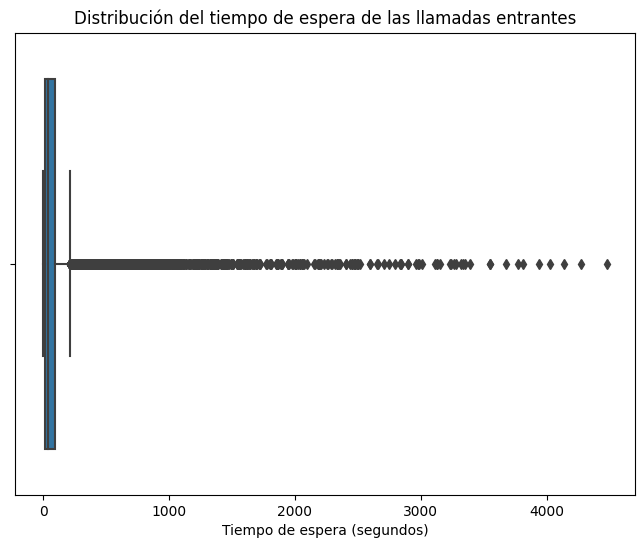

In [ ]:
# Filtrar las llamadas entrantes
llamadas_entrantes = df_llamadas_2[df_llamadas_2['direction'] == 'in']

# Calcular el tiempo de espera para cada llamada
llamadas_entrantes['tiempo_espera'] = llamadas_entrantes['total_call_duration']\
                                    - llamadas_entrantes['call_duration']

# Grafico
plt.figure(figsize=(8,6))
sns.boxplot(x=llamadas_entrantes['tiempo_espera'])
plt.title('Distribución del tiempo de espera de las llamadas entrantes')
plt.xlabel('Tiempo de espera (segundos)')
plt.show()

La distribución del tiempo de espera y su promedio, muestra que la mayoría de las llamadas son
atendidas casi inmediatamente. No obstante, la presencia de valores atípicos indica que un grupo
de clientes experimenta esperas significativamente más largas. Es necesario investigar las causas de
estos tiempos de espera excesivos para optimizar el servicio.

**Hipótesis 2 (tiempo de espera):**

- H₀: El tiempo promedio de espera no difiere entre operadores eficaces e ineficaces.

- H₁: Los operadores ineficaces tienen tiempos de espera significativamente mayores.

In [ ]:
np.percentile(llamadas_entrantes["tiempo_espera"],90)

235.0

In [ ]:

llamadas_entrantes["operadores_lentos"]= llamadas_entrantes["tiempo_espera"]>235



/tmp/ipykernel_2344/4260467588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llamadas_entrantes["operadores_lentos"]= llamadas_entrantes["tiempo_espera"]>235


In [ ]:
llamadas_entrantes.groupby("operadores_lentos")["tiempo_espera"].describe()

,count,mean,std,min,25%,50%,75%,max
operadores_lentos,,,,,,,,
False,19334.0,49.029740,51.424383,0.0,12.0,30.0,67.00,235.0
True,2146.0,622.719944,551.832015,236.0,306.0,415.5,703.25,4476.0


Conclusion el analisis revela que el 10% de los operadores supera los 235 segundos en tiempo de espera promedio. Esto los clasifica como lentos . Estos operadores presentan un tiempo de espera promedio ,casi trece veces mayor que el resto del grupo .

In [ ]:
llamadas_entrantes["operadores_rapidos"]= llamadas_entrantes["tiempo_espera"]<=235


/tmp/ipykernel_2344/828964504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llamadas_entrantes["operadores_rapidos"]= llamadas_entrantes["tiempo_espera"]<=235


In [ ]:
tiempos_lentos=llamadas_entrantes[llamadas_entrantes["operadores_lentos"]]["tiempo_espera"]
tiempos_rapidos=llamadas_entrantes[llamadas_entrantes["operadores_rapidos"]]["tiempo_espera"]

stat,p=stats.shapiro(tiempos_lentos)
print("operadores_lentos")
print("estadistico_de_shapiro",stat)
print("p_valor",p)

if p>0.05:
    print("los datos se distribuyen de forma normal")
else:
    print("los datos no se distribuyen de forma normal")

print("-"*50)

stat,p=stats.shapiro(tiempos_rapidos)
print("operadores_rapidos")

print("estadistico_de_shapiro",stat)
print("p_valor",p)

if p>0.05:
    print("los datos se distribuyen de forma normal")
else:
    print("los datos no se distribuyen de forma normal")


operadores_lentos
estadistico_de_shapiro 0.6568282246589661
p_valor 0.0
los datos no se distribuyen de forma normal
--------------------------------------------------
operadores_rapidos
estadistico_de_shapiro 0.8137766718864441
p_valor 0.0
los datos no se distribuyen de forma normal


/.venv/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
U1,p=mannwhitneyu(tiempos_lentos,tiempos_rapidos)
print("estadistico_de_mannwhitneyu",U1)
print("p_valor",p)

if p>0.05:
    print("Exsiste una diferencia significativa en los tiempos de espera entre los 2 grupos")
else:
    print("No se encontro una diferencia significativa")


estadistico_de_mannwhitneyu 41490764.0
p_valor 0.0
No se encontro una diferencia significativa


**Hipótesis 3 (llamadas salientes):**

- H₀: No hay diferencia en el número de llamadas salientes realizadas por operadores clasificados como ineficaces.

- H₁: Los operadores ineficaces realizan significativamente menos llamadas salientes.

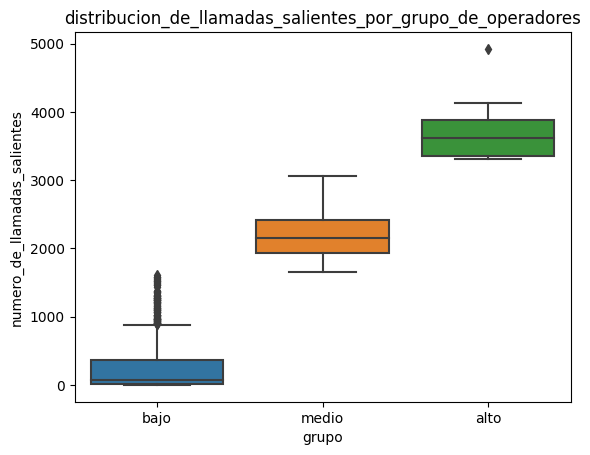

In [ ]:
llamadas_salientes=df_llamadas_2[df_llamadas_2["direction"]=="out"]

llamadas_por_operador=llamadas_salientes.groupby("operator_id")["calls_count"].sum().reset_index()

labels=["bajo","medio","alto"]
llamadas_por_operador["grupo"]=pd.cut(llamadas_por_operador["calls_count"],bins=3,labels=labels)

sns.boxplot(x="grupo",y="calls_count",data=llamadas_por_operador)

plt.title("distribucion_de_llamadas_salientes_por_grupo_de_operadores")
plt.xlabel("grupo")
plt.ylabel("numero_de_llamadas_salientes")
plt.show()


Los resultados obtenidos indican una distribucion desigual de la carga de trabajo entre los operadores . La alta consentracion de llamadas en el grupo alto sugiere la necesidad de redistribuir las tareas o proporcionar recursos adicionales a estos operadores . Ademas , el analisis del outlier en este grupo podria revelar oportunidades de optimizacion o areas donde se requiere atencion especial.

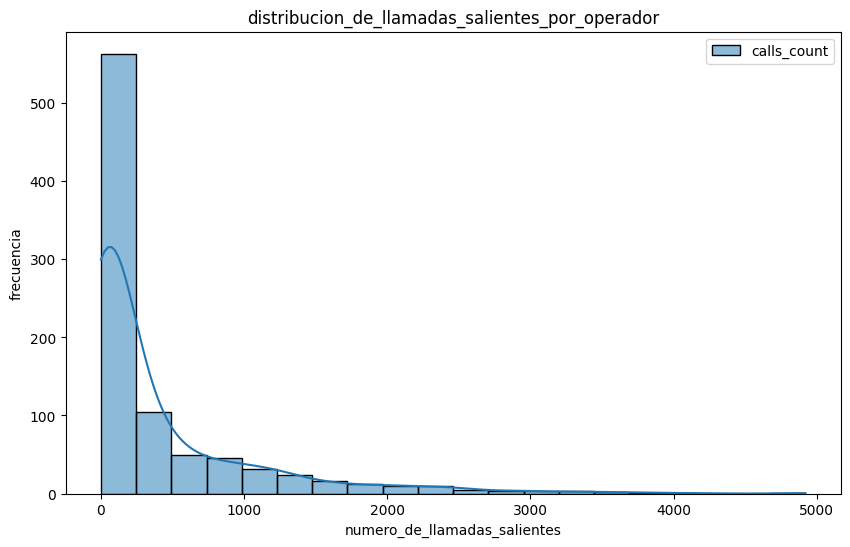

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=llamadas_por_operador,bins=20,kde=True)

plt.title("distribucion_de_llamadas_salientes_por_operador")
plt.xlabel("numero_de_llamadas_salientes")
plt.ylabel("frecuencia")
plt.show()



In [ ]:
llamadas_por_operador.mean()

calls_count    403.420159
dtype: float64

In [ ]:
percentil_25=np.percentile(llamadas_por_operador["calls_count"],25)
print("el_percentil_25_de_llamadas_por_operador_es",percentil_25)

el_percentil_25_de_llamadas_por_operador_es 12.5


In [ ]:
operadores_bajo_percentil=llamadas_por_operador[llamadas_por_operador["calls_count"]<percentil_25]["operator_id"]
print("operadores_por_debajo_del_percentil_25")
operadores_bajo_percentil

operadores_por_debajo_del_percentil_25


8      882478.0
13     883018.0
14     883898.0
17     884402.0
18     884406.0
         ...   
874    970258.0
875    970484.0
876    970486.0
877    972408.0
881    973120.0
Name: operator_id, Length: 221, dtype: object

Existe una gran disparidad en el numero del llamadas salientes realizadas por cada operador . Donde el operador que mas llamadas atiende tiene un total de 4.921 llamadas . Un pequeño grupo de operadores concentra un volumen significativamente mayor de llamadas en comparacion con el resto del equipo. Hay un numero considerable de operadores (221)que realizan muy pocas llamadas salientes, por debajo de 12 llamadas , incluso algunos solo una. Esto podria indicar problemas de asignacion de tareas, falta de capacitacion o factores externos que afectan su productividad . Posible necesidad de reasignacion , la concentracion de llamadas en pocos operadores podrian indicar una sobrecarga de trabajo para ellos y una posible subutilizacion de otros. Podria ser necesario reasignar las tareas para distribuir la carga de trabajo de manera mas equitativa.

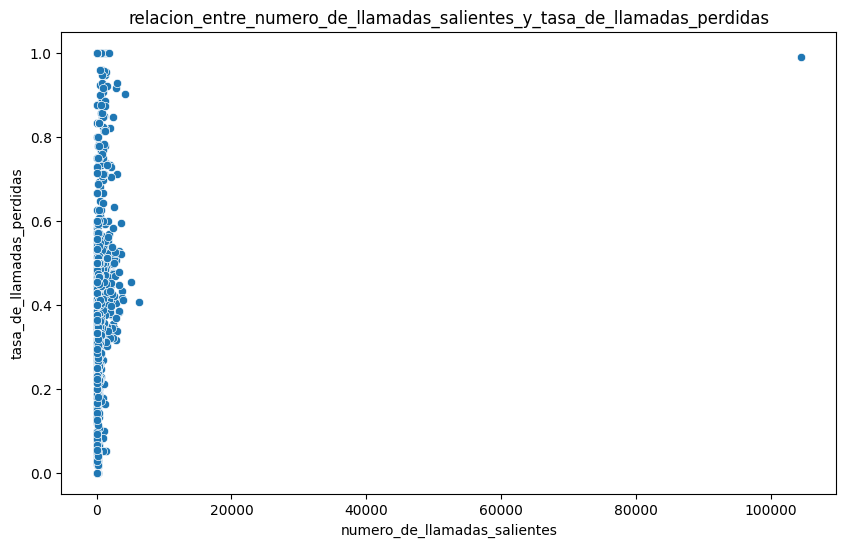

In [ ]:
grouped_data=df_llamadas_2.groupby("operator_id").agg(calls_count=("calls_count","sum"),missed_call_rate=("is_missed_call","mean"))
plt.figure(figsize=(10,6))
sns.scatterplot(x="calls_count",y="missed_call_rate",data=grouped_data)
plt.title("relacion_entre_numero_de_llamadas_salientes_y_tasa_de_llamadas_perdidas")
plt.xlabel("numero_de_llamadas_salientes")
plt.ylabel("tasa_de_llamadas_perdidas")
plt.show()


No se observa una relacion clara entre el numero de llamasas salientes y la tasa de llamadas perdidas . Otros factores como la complejidad de las llamadas o la disponibilidad de los agentes podria estar influyendo en la tasa de perdidas .


## Conclucion y Recomendaciones
El analisis exaustivo de los datos de llamadas a revelado una heterogeneidad significativa en el desempeño de los operadores de Callme maybe. Se identificaron brechas significativas en terminos de volumen de llamadas , tiempos de espera, tasas de llamadas perdidas y eficiencia en la resolucion de incidentes.

Los resultados evidencias que un porsentaje considerable de operadores no cumple con los estandares establecidos, lo que impacta directamente en la satisfaccion del cliente y la reputacion de la empresa. Las causas de este bajo desempeño son multifactoriales y abarcan desde la falta de capacitacion y experiencia hasta problemas en la asignacion de tares y la gestion de recursos.

**Recomendaciones**
1.- Mejora de las condiciones laborales y el trato
2.- Revicion de la remuneracion (salarios)
3.- Fortalecimiento de la capacitacion y el desarrollo
4.- Comunicacion efectiva (canales de comunicacion abiertos)

Al implementar estas recomendaciones, callmymaybe podra mejorar significativamente la calidad de su servicio , aumentar la satisfaccion de cliente y fortalecer su posicion en el mercado. Es fundamental que la empresa se comprometa con un proceso de mejora continua y que invierta en el desarollo de sus operadores para garantizar el exito a largo plazo.

Enlace a precentacion
https://gamma.app/docs/yfl6qcowywzl8r0?following_id=c1nf16twayxs8m3&follow_on_start=true